# Comparison of astroNN-DR17 and ASPCAP DR16 metallicities

In [1]:
from utils import *

# Plot settings
plt.rc(('xtick', 'ytick'), direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('font', family='STIXgeneral')
plt.rc('figure', dpi=140)
plt.rc('figure', figsize=(4, 4))

# Paths
# data_dir = '/users/PAS2055/lodubay/Data/APOGEE'
# data_dir = 'C:\\Users\\dubay.11\\Data\\APOGEE'
data_dir = '/home/dubay.11/Documents/Data/APOGEE'
data_path = Path(data_dir)

stellar_params = import_catalogs(data_path)

Importing APOKASC catalog...
Importing astroNN DR17 catalog...
Importing StarHorse DR17 catalog...
Combining datasets...
Cleaning up...
Combining columns...
Done!


## Finding stars with discrepancies in metallicity

There's a group of stars whose metallicities are extremely underestimated by astroNN as compared to ASPCAP. ASPCAP puts them in the -0.5 to 0 dex range, while astroNN puts them anywhere from 0.5 dex (my arbitrary cutoff) to 3.5 dex lower. I'm not sure if the problem exclusively affects stars in the -0.5 to 0 dex [M/H] range, or whether it's just most noticeable there because that's where most of the stars are. The astroNN paper states that they do poorly for [Fe/H] < -0.7 because there isn't much training data in that regime and the spectral features are less informative. The astroNN metallicities definitely start to diverge from ASPCAP by ~-1.7. I haven't found anything in the paper which hints at what might be causing the discrepancy for higher metallicities, though.

StarHorse doesn't seem to have the same problem (well, there are a few underestimated stars but not many), though the scatter around the ASPCAP values is slightly larger, and StarHorse systematically overestimates the lowest metallicities by ~0.1 dex. Interestingly, for the stars where astroNN struggles, StarHorse generally gets it right. The bottom right panel shows that the stars astroNN gets wrong and the stars that StarHorse gets wrong are generally not the same stars. Perhaps we could get around the [M/H] discrepancies by relying on astroNN for all stars except where astroNN and StarHorse differ substantially, and for those switch to StarHorse. Or we could use only data with good agreement between the two.

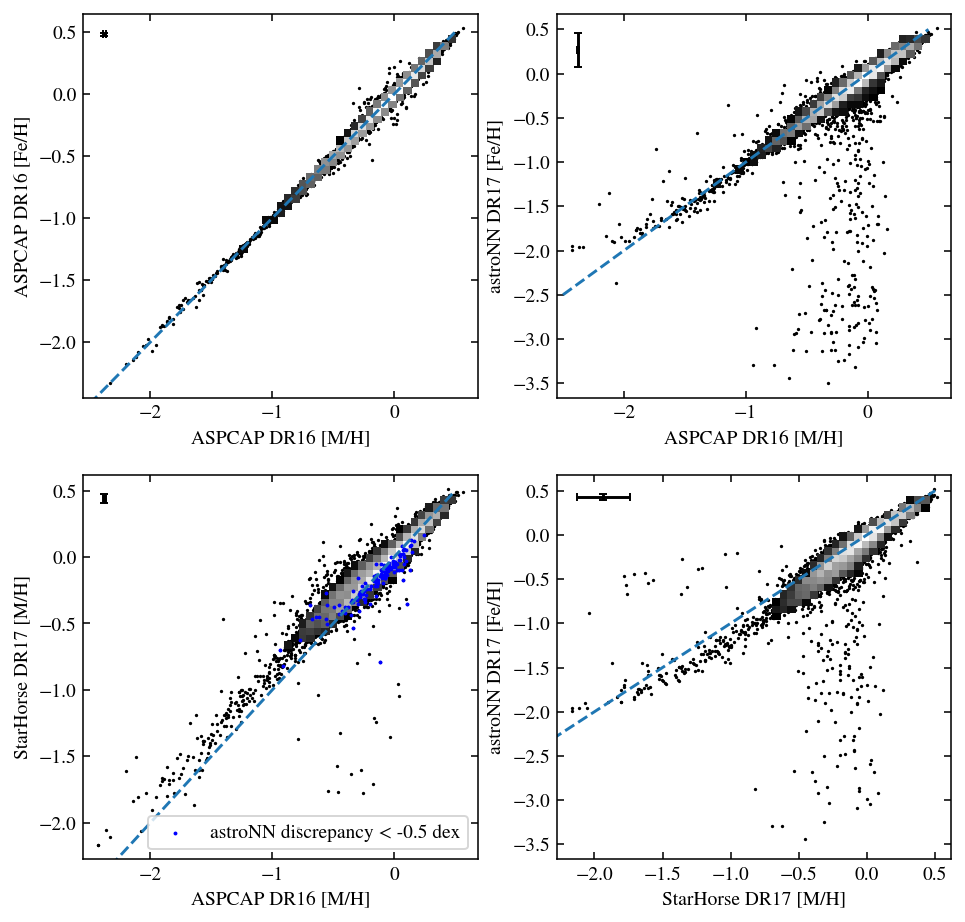

In [12]:
metals, low_fe = get_discrepant_metallicities(stellar_params, diff_cut=-0.5)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

ax = axs[0,0]
scatter_hist(ax, metals['DR16_M_H_COR'], metals['DR16_FE_H'])
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
plot_rms_err(ax, metals['DR16_M_H_COR_ERR'], metals['DR16_FE_H_ERR'])
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('ASPCAP DR16 [Fe/H]')

ax = axs[0,1]
scatter_hist(ax, metals['DR16_M_H_COR'], metals['ASTRONN_FE_H'])
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
plot_rms_err(ax, metals['DR16_M_H_COR_ERR'], metals['ASTRONN_FE_H_ERR'])
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('astroNN DR17 [Fe/H]')

ax = axs[1,0]
scatter_hist(ax, metals['DR16_M_H_COR'], metals['STARHORSE_M_H'])
ax.scatter(low_fe['DR16_M_H_COR'], low_fe['STARHORSE_M_H'], s=1, c='b', label='astroNN discrepancy < -0.5 dex')
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
plot_rms_err(ax, metals['DR16_M_H_COR_ERR'], metals[['STARHORSE_M_H_MERR', 'STARHORSE_M_H_PERR']])
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('StarHorse DR17 [M/H]')
ax.legend()

ax = axs[1,1]
scatter_hist(ax, metals['STARHORSE_M_H'], metals['ASTRONN_FE_H'])
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
plot_rms_err(ax, metals['ASTRONN_FE_H_ERR'], metals[['STARHORSE_M_H_MERR', 'STARHORSE_M_H_PERR']])
ax.set_xlabel('StarHorse DR17 [M/H]')
ax.set_ylabel('astroNN DR17 [Fe/H]')

plt.show()

The same trends show up more clearly when we look at the full astroNN and StarHorse sample.

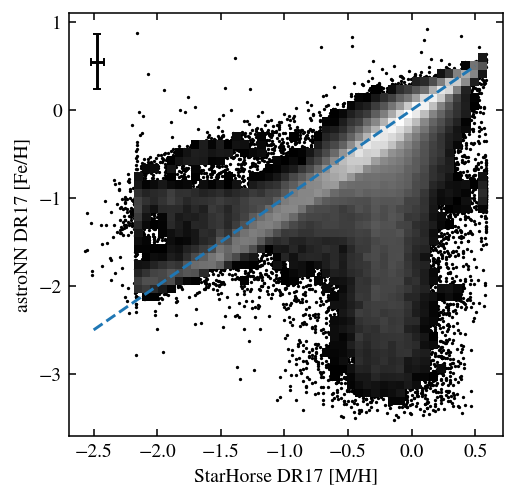

In [24]:
# Eliminate obviously bad data
sensible_metals = stellar_params[(stellar_params['ASTRONN_FE_H'] >= -4) & \
                                 (stellar_params['ASTRONN_FE_H'] <= 1) & \
                                 (stellar_params['ASTRONN_FE_H_ERR'] <= 5) & \
                                 (pd.notna(stellar_params['STARHORSE_M_H']))].copy()

# Plot full Starhorse & astroNN sample
fig, ax = plt.subplots()
scatter_hist(ax, sensible_metals['STARHORSE_M_H'], sensible_metals['ASTRONN_FE_H'])
plot_rms_err(ax, sensible_metals[['STARHORSE_M_H_MERR', 'STARHORSE_M_H_PERR']], sensible_metals['ASTRONN_FE_H_ERR'])
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
ax.set_xlabel('StarHorse DR17 [M/H]')
ax.set_ylabel('astroNN DR17 [Fe/H]')
plt.show()

Below I use StarHorse to find the discrepant astroNN metallicities and substitute StarHorse's own values. I found that a boundary at -0.3 dex difference was close to a sweet spot of minimizing the mean difference from ASPCAP while also minimizing scatter about the mean.

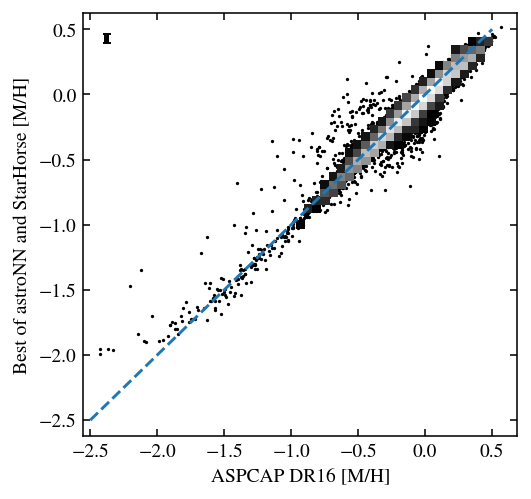

Stars remaining: 546798
Mean [M/H] difference: -0.01920051872730255
Scatter about mean: 0.05290062725543976


In [51]:
# Choose astroNN as the 'best' [Fe/H] except where (astroNN [Fe/H] - StarHorse [M/H]) < -0.3 dex,
# then use StarHorse
sensible_metals['M_H_DIFF'] = sensible_metals['ASTRONN_FE_H'] - sensible_metals['STARHORSE_M_H']
sensible_metals['BEST_M_H'] = sensible_metals['ASTRONN_FE_H'].copy()
sensible_metals['BEST_M_H_MERR'] = sensible_metals['ASTRONN_FE_H_ERR'].copy()
sensible_metals['BEST_M_H_PERR'] = sensible_metals['ASTRONN_FE_H_ERR'].copy()
discrep_met = sensible_metals['M_H_DIFF'] < -0.3
sensible_metals.loc[discrep_met, 'BEST_M_H'] = sensible_metals[discrep_met]['STARHORSE_M_H'].copy()
sensible_metals.loc[discrep_met, 'BEST_M_H_MERR'] = sensible_metals[discrep_met]['STARHORSE_M_H_MERR'].copy()
sensible_metals.loc[discrep_met, 'BEST_M_H_PERR'] = sensible_metals[discrep_met]['STARHORSE_M_H_PERR'].copy()

fig, ax = plt.subplots()
scatter_hist(ax, sensible_metals['DR16_M_H_COR'], sensible_metals['BEST_M_H'], ylim=(-2.5, 0.5))
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('Best of astroNN and StarHorse [M/H]')
plot_rms_err(ax, sensible_metals['DR16_M_H_COR_ERR'],
             sensible_metals[pd.notna(sensible_metals['DR16_M_H_COR'])][['STARHORSE_M_H_MERR', 'STARHORSE_M_H_PERR']])
plt.show()

print('Stars remaining:', sensible_metals.shape[0])
print('Mean [M/H] difference:', np.mean(sensible_metals['BEST_M_H'] - sensible_metals['DR16_M_H_COR']))
print('Scatter about mean:', np.std(sensible_metals['BEST_M_H'] - sensible_metals['DR16_M_H_COR']))

Alternatively, we can look at the difference between StarHorse and astroNN metallicities, and cut targets where the difference is greater than desired. Placing the cut at 0.3 dex results in losing about 44,000 targets, a similar mean difference from ASPCAP and very slightly smaller scatter about the mean. Placing the cut any smaller starts to result in significant losses to the target sample for not much improvement in accuracy.

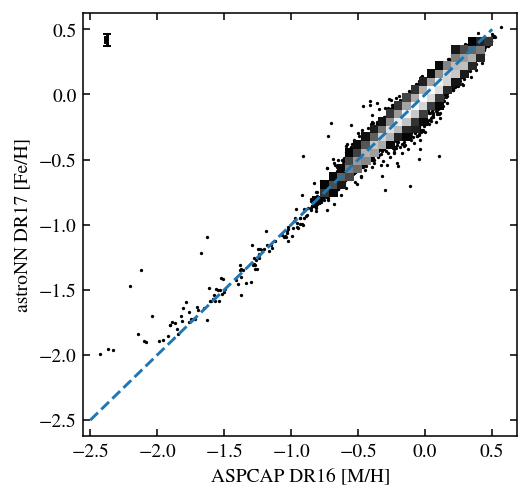

Stars remaining: 457162
Mean [M/H] difference: -0.019650854170322418
Scatter about mean: 0.04205617681145668


In [58]:
best_metals = sensible_metals[np.abs(sensible_metals['M_H_DIFF']) < 0.2].copy()

fig, ax = plt.subplots()
scatter_hist(ax, best_metals['DR16_M_H_COR'], best_metals['ASTRONN_FE_H'], ylim=(-2.5, 0.5))
ax.plot([-2.5, 0.5], [-2.5, 0.5], linestyle='--')
ax.set_xlabel('ASPCAP DR16 [M/H]')
ax.set_ylabel('astroNN DR17 [Fe/H]')
plot_rms_err(ax, best_metals['DR16_M_H_COR_ERR'],
             best_metals[pd.notna(best_metals['DR16_M_H_COR'])]['ASTRONN_FE_H_ERR'])
plt.show()

print('Stars remaining:', best_metals.shape[0])
print('Mean [M/H] difference:', np.mean(best_metals['ASTRONN_FE_H'] - best_metals['DR16_M_H_COR']))
print('Scatter about mean:', np.std(best_metals['ASTRONN_FE_H'] - best_metals['DR16_M_H_COR']))